In [1]:
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn import preprocessing

1. Загружаем Mushrooms, делаем DataFrame

Вычисляем распределение признаков по классам

Визуализируем распределение

In [2]:
mashrooms = pd.read_csv('mushrooms.csv')

In [3]:
# percentage_df = []
# properties = mashrooms.drop(columns=['class']).columns

# for one_prop in properties:
#     temp_df = mashrooms[['class', one_prop]]
#     result = temp_df.groupby('class').value_counts(normalize=True).reset_index()
#     result = result.rename(columns={one_prop: 'property_data', 0: 'propery_percentage'})
#     result['property_name'] = one_prop
#     percentage_df.append(result)

# percentage_df = pd.concat(percentage_df)

In [99]:
# percentage_df[percentage_df['property_name'] == properties[4]]
mashrooms.groupby('odor')['class'].value_counts().unstack().fillna(0)

class,e,p
odor,,
a,400.0,0.0
c,0.0,192.0
f,0.0,2160.0
l,400.0,0.0
m,0.0,36.0
n,3408.0,120.0
p,0.0,256.0
s,0.0,576.0
y,0.0,576.0


0'cap-shape', 1'cap-surface', 2'cap-color', 3'bruises', 4'odor',
5'gill-attachment', 6'gill-spacing', 7'gill-size', 8'gill-color',
9'stalk-shape', 10'stalk-root', 11'stalk-surface-above-ring',
12'stalk-surface-below-ring', 13'stalk-color-above-ring',
14'stalk-color-below-ring', 15'veil-type', 16'veil-color', 17'ring-number',
18'ring-type', 19'spore-print-color', 20'population', 21'habitat'

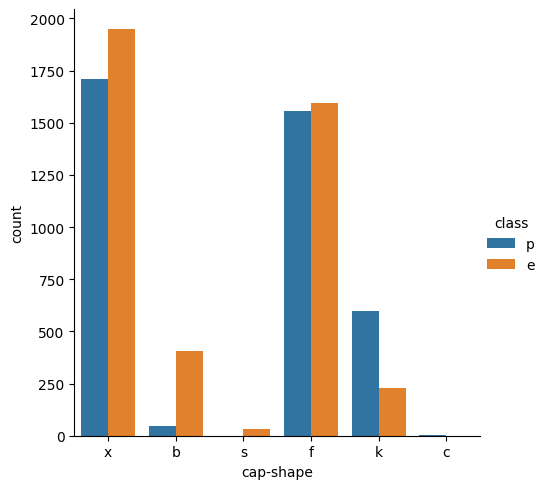

In [5]:
to_visual = properties[0]
sns.catplot(x = to_visual, data=mashrooms, hue='class',kind = 'count' )

2. Построить решающую функцию по каждой переменной на основе частот

вычислить точность каждого решения

найти наиболее информативную переменную

In [6]:
X = mashrooms.drop(columns=['class'])
y = mashrooms['class']

In [7]:
y.value_counts(normalize=True).reset_index()

,index,class
0,e,0.517971
1,p,0.482029


In [8]:
def get_prob_col(column,j, alpha = 0):
    global X
    global y
    prob = {}
    x = X[column]
    x = x[y == j]
    k = len(X[column].unique())
    for i in X[column].unique():
        prob[i] = (x[x == i].count() + alpha) / (x.count() + alpha * k)
    return prob
    
def predict(X,column):
    global y
    y_pred = []
    prob0 = get_prob_col(column,'e')
    prob1 = get_prob_col(column,'p')
    p0 = y[y == 'e'].count() / y.count()
    p1 = y[y == 'p'].count() / y.count()
    for k in X[column]:
        if p0 * prob0[k] < p1 * prob1[k]:
            y_pred.append('p')
        else:
            y_pred.append('e')
    return np.array(y_pred)

In [9]:
results = {
    'column_name': list(),
    'score_train': list()
}
for col in X.columns:
    results['column_name'].append(col)
    results['score_train'].append(accuracy_score(y, predict(X,col)))
results_df = pd.DataFrame(results)

In [10]:
results_df.sort_values('score_train', ascending=False)
# gill-color

,column_name,score_train
4,odor,0.985229
19,spore-print-color,0.868045
8,gill-color,0.805022
18,ring-type,0.775480
11,stalk-surface-above-ring,0.774495
12,stalk-surface-below-ring,0.766125
7,gill-size,0.756278
3,bruises,0.743968
20,population,0.721812
13,stalk-color-above-ring,0.716396


3. Наивный байесовский классификатор из sklearn

In [101]:
X_c = X.copy()
y_c = y.copy()
for i in X_c:
    X_c[i]=LabelEncoder().fit_transform(X_c[i])
y_c = LabelEncoder().fit_transform(y_c)
model = sklearn.naive_bayes.CategoricalNB(alpha=1).fit(X_c,y_c)
print(accuracy_score(y_c, model.predict(X_c)))

0.9566715903495815


4. написать самому

In [102]:
def get_prob_col(column,j, alpha = 0):
    global X
    global y
    prob = {}
    x = X[column]
    x = x[y == j]
    k = len(X[column].unique())
    for i in X[column].unique():
        prob[i] = (x[x == i].count() + alpha) / (x.count() + alpha * k)
    return prob

def get_prob(j,alpha = 0):
    prob = {}
    for col in X.columns:
        prob[col] = (get_prob_col(col,j,alpha))
    return prob

def predict(X, alpha = 0):
    prob0 = get_prob('e',alpha= alpha)
    prob1 = get_prob('p',alpha = alpha)
    p0 = y[y == 'e'].count() / y.count()
    p1 = y[y == 'p'].count() / y.count()
    y_pred = []
    for i in range(len(X)):
        prod0 = p0
        prod1 = p1
        for col in X.columns:
            prod0 *= prob0[col][X[i:i+1][col].values[0]]
            prod1 *= prob1[col][X[i:i+1][col].values[0]]
        if p0 * prod0 < p1 * prod1:
            y_pred.append('p')
        else:
            y_pred.append('e')
    return y_pred
accuracy_score(predict(X, alpha=1), y)

0.9559330379123584

In [13]:
from sklearn.linear_model import LogisticRegression
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

[0.84431273 0.19998395 0.06701388 ... 0.06816805 0.92580453 0.01165206]


/home/develop_user/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


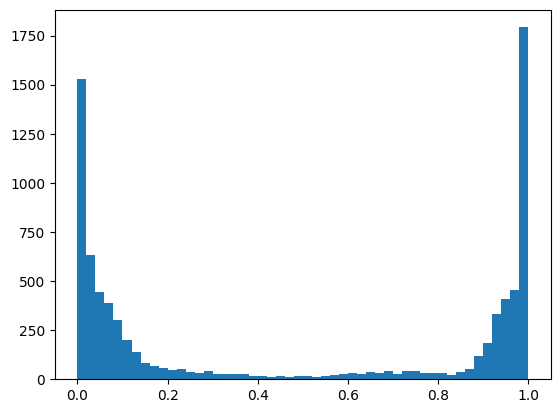

In [14]:
model = LogisticRegression()
X_c = X.copy()
y_c = y.copy()
for i in X_c:
    X_c[i]=LabelEncoder().fit_transform(X_c[i])
y_c = LabelEncoder().fit_transform(y_c)
model.fit(X_c,y_c)
probs = model.predict_proba(X_c)[:,1]
print(probs) # просто логистическая регрессия
plt.hist(probs, 50)
plt.show()

[1.00000000e+00 8.87982121e-04 6.43761906e-04 ... 4.76943513e-09
 9.96594313e-01 1.31882191e-08]


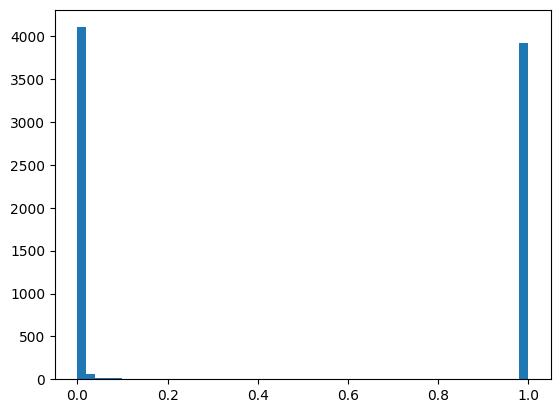

In [96]:
model = LogisticRegression()

mashrooms_c = mashrooms.copy()

for col in mashrooms_c.columns: # для каждой колонки считаем оценки вероятности 
    if col != 'class':
        varoyatnost = mashrooms.groupby(col)['class'].value_counts(normalize=True).unstack().fillna(0)
        mashrooms_c[col] = mashrooms_c[['class', col]].apply(lambda x: varoyatnost[x[0]].loc[x[1]], axis=1)

        mashrooms_c[col] = np.log(mashrooms_c[col]/(1-mashrooms_c[col])) # и делаем обратное логистическое преобразования

        mashrooms_c[col] = mashrooms_c[col].apply(lambda x: 0 if x == np.inf else x) # при оценке вероятности 1 получается бесконечность, зануляем
        
X_c = mashrooms_c.drop(columns='class')
y_c = mashrooms_c['class'].copy()

y_c = LabelEncoder().fit_transform(y_c)
model.fit(X_c,y_c)
probs = model.predict_proba(X_c)[:,1]

print(probs) # с обратным логистическим преобразованием
plt.hist(probs, 50)
plt.show()

In [98]:
mashrooms_c

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,-0.131480,0.210476,-0.214479,-1.483933,0.000000,-0.029823,0.234778,2.044102,-1.681759,...,-0.794594,-0.474666,-0.475938,-0.071917,-0.027261,0.034191,-1.351378,-1.995672,-0.871839,1.041454
1,e,0.131480,-0.210476,-0.518794,1.483933,0.000000,0.029823,-0.234778,0.840180,1.681759,...,0.794594,0.474666,0.475938,0.071917,0.027261,-0.034191,1.351378,2.052291,0.000000,0.643275
2,e,2.130214,-0.210476,0.810930,1.483933,0.000000,0.029823,-0.234778,0.840180,2.123117,...,0.794594,0.474666,0.475938,0.071917,0.027261,-0.034191,1.351378,2.052291,0.000000,1.961659
3,p,-0.131480,0.145757,-0.810930,-1.483933,0.000000,-0.029823,0.234778,2.044102,-2.123117,...,-0.794594,-0.474666,-0.475938,-0.071917,-0.027261,0.034191,-1.351378,-1.995672,-0.871839,1.041454
4,e,0.131480,-0.210476,0.244692,-0.815802,3.346389,0.029823,2.371578,0.840180,1.681759,...,0.794594,0.474666,0.475938,0.071917,0.027261,-0.034191,-0.561881,2.052291,0.000000,0.643275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,-0.967584,-0.210476,0.214479,-0.815802,3.346389,2.367124,-0.234778,0.840180,1.067841,...,0.794594,0.000000,0.000000,0.071917,0.000000,-0.034191,1.351378,0.000000,1.711717,-0.902868
8120,e,0.131480,-0.210476,0.214479,-0.815802,3.346389,2.367124,-0.234778,0.840180,1.067841,...,0.794594,0.000000,0.000000,0.071917,0.000000,-0.034191,1.351378,0.000000,-0.870984,-0.902868
8121,e,0.025382,-0.210476,0.214479,-0.815802,3.346389,2.367124,-0.234778,0.840180,2.123117,...,0.794594,0.000000,0.000000,0.071917,0.000000,-0.034191,1.351378,0.000000,1.711717,-0.902868
8122,p,0.967584,0.145757,-0.214479,0.815802,0.000000,-0.029823,0.234778,2.044102,0.000000,...,2.708050,-0.474666,-0.475938,-0.071917,-0.027261,0.034191,0.561881,1.146079,0.870984,0.902868


In [109]:
mashrooms.groupby('cap-shape')['class'].value_counts(normalize=True).unstack()

class,e,p
cap-shape,,
b,0.893805,0.106195
c,NaN,1.000000
f,0.506345,0.493655
k,0.275362,0.724638
s,1.000000,NaN
x,0.532823,0.467177


In [100]:
accuracy_score(np.where(probs >= 0.5, 1, 0), y_c)

1.0

In [110]:
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
find_nearest(probs, 0.5)

0.09467881131887103

In [51]:
X_c = X.copy()

0.8938053097345132